In [1]:
from pprint import pp

In [ ]:
# Residual plots
IS_PLOT_RES = False
SAVE_PLOT_RES = False

# Combined plots
SAVE_PLOT = False

# Data
SAVE_DATA = False

### Class definitions
Note that in real production you should put this definition in a separate .py file and import it. 
For example

```python
from classes_v1 import DataHandler, MyUtil, RegSwitcher
```

In [3]:
import pickle
from datetime import datetime
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import (
    PredictionErrorDisplay,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
)
import pandas as pd


class MyUtil:
    def save_data(filename, data):
        with open(filename, "wb") as file:
            pickle.dump(data, file)

    def load_data(filename):
        with open(filename, "rb") as file:
            data = pickle.load(file)
        return data

    def get_dt():
        return datetime.now().strftime("%Y-%m-%d_%H-%M")


class DataHandler:
    def __init__(self, _X, _Y, scalerX, scalerY):
        self._X = _X
        self._Y = _Y
        self.scalerX = scalerX
        self.scalerY = scalerY
        self.X_train = None
        self.X_test = None
        self.Y_train = None
        self.Y_test = None

    def split_and_scale(self, test_size, random_state):
        _X_train, _X_test, _Y_train, _Y_test = train_test_split(
            self._X, self._Y, test_size=test_size, random_state=random_state
        )
        self.X_train = self.scalerX.fit_transform(_X_train)
        self.X_test = self.scalerX.transform(_X_test)

        self.Y_train = self.scalerY.fit_transform(_Y_train)
        self.Y_test = self.scalerY.transform(_Y_test)

    def get_train(self):
        return self.X_train, self.Y_train

    def get_test(self):
        return self.X_test, self.Y_test


class RegSwitcher(BaseEstimator):
    def __init__(self, base=None):
        self.base = base
        self.dt = datetime.now().strftime("%Y-%m-%d_%H-%M")

    def fit(self, X, Y):
        self.base.fit(X, Y)
        self.is_fitted_ = True
        return self

    def predict(self, X):
        return self.base.predict(X)


class MyEval:
    @staticmethod
    def eval_perf(y_true, y_pred):
        mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
        mape = mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred)
        r2 = r2_score(y_true=y_true, y_pred=y_pred)
        return mse, mape, r2

    @staticmethod
    def pp():
        print("no")

    @classmethod
    def eval(cls, Y_train, Y_test, Y_train_pred, Y_test_pred, **kwargs):
        data_arr = []
        for i in range(0, Y_train.shape[1]):
            mse_train, mape_train, r2_train = cls.eval_perf(
                y_true=Y_train[:, i], y_pred=Y_train_pred[:, i]
            )
            mse_test, mape_test, r2_test = cls.eval_perf(
                y_true=Y_test[:, i], y_pred=Y_test_pred[:, i]
            )

            data = {
                **kwargs,
                "Y": f"Y-{i + 1}",
                "MSE Train (No Val)": mse_train,
                "MSE Test": mse_test,
                "MAPE Train (No Val)": mape_train,
                "MAPE Test": mape_test,
                "R2 Train (No Val)": r2_train,
                "R2 Test": r2_test,
            }
            data_arr.append(data)

        mse_train, mape_train, r2_train = cls.eval_perf(
            y_true=Y_train, y_pred=Y_train_pred
        )
        mse_test, mape_test, r2_test = cls.eval_perf(y_true=Y_test, y_pred=Y_test_pred)
        data = {
            **kwargs,
            "Y": "Y-All",
            "MSE Train (No Val)": mse_train,
            "MSE Test": mse_test,
            "MAPE Train (No Val)": mape_train,
            "MAPE Test": mape_test,
            "R2 Train (No Val)": r2_train,
            "R2 Test": r2_test,
        }
        data_arr.append(data)
        df_eval = pd.DataFrame.from_dict(data_arr)
        return df_eval

    @classmethod
    def plot_res(
        cls,
        Y_train,
        Y_test,
        Y_train_pred,
        Y_test_pred,
        dt="",
        save=False,
        show=True,
        file_prefix="",
    ):
        for i in range(0, Y_train.shape[1]):
            fig, axes = plt.subplots(
                nrows=1,
                ncols=2,
                figsize=(10, 5),
                constrained_layout=True,
                sharex=True,
                sharey=True,
            )

            display_train = PredictionErrorDisplay(
                y_true=Y_train[:, i], y_pred=Y_train_pred[:, i]
            )
            display_train.plot(ax=axes[0])
            axes[0].set_title("Train")

            display_train = PredictionErrorDisplay(
                y_true=Y_test[:, i], y_pred=Y_test_pred[:, i]
            )
            display_train.plot(ax=axes[1])
            axes[1].set_title("Test")

            if file_prefix != "":
                fig.suptitle(file_prefix)

            if save:
                if file_prefix == "":
                    raise Exception("Please specify file prefix")

                filename = f"{file_prefix}_{dt}_{i}.png"
                fig.savefig(filename, dpi=300)

            if show:
                plt.show()


### Load data


In [4]:
# Search for pkl files
from os import listdir
from os.path import isfile, join

onlyfiles = [f for f in listdir(".") if (isfile(join(".", f)) and f.endswith("pkl"))]
pp(onlyfiles)

['S04_data_2025-05-19_12-06.pkl',
 'S05_data_2025-05-19_12-06.pkl',
 'S05_data_2025-05-19_12-15.pkl']


In [5]:
filenameInput = "S04_data_2025-05-19_12-06.pkl"
data_load = MyUtil.load_data(filename=filenameInput)

# Print keys
pp([k for k in data_load.keys()])


['desc', 'data_handler', 'param_split', 'param_grid_hyper', 'df_cv']


In [6]:
dt = MyUtil.get_dt()

In [7]:
data_handler = data_load["data_handler"]
df_cv = data_load["df_cv"]

In [8]:
df_cv

,id_split,param_split,id_gs,params,estimator,mean_test_score,std_test_score,rank_test_score,validation_scores
0,0,"{'random_state': 1, 'test_size': 0.3}",0,{'base': MultiOutputRegressor(estimator=Linear...,LinearRegression,-2.372222,3.924419,7,"[0.0381745359446262, 0.7520240440765592, -7.90..."
1,0,"{'random_state': 1, 'test_size': 0.3}",1,{'base': MultiOutputRegressor(estimator=SVR())...,SVR,-0.006503,0.027330,6,"[-0.0022755109373579683, -0.04188876497945082,..."
2,0,"{'random_state': 1, 'test_size': 0.3}",2,{'base': MultiOutputRegressor(estimator=SVR())...,SVR,0.304896,0.003312,5,"[0.302294515805052, 0.3095696294549572, 0.3028..."
3,0,"{'random_state': 1, 'test_size': 0.3}",3,{'base': MultiOutputRegressor(estimator=SVR())...,SVR,0.744229,0.089645,4,"[0.6177065038720949, 0.8144446900525925, 0.800..."
4,0,"{'random_state': 1, 'test_size': 0.3}",4,{'base': MultiOutputRegressor(estimator=Random...,RandomForestRegressor,0.752071,0.059197,3,"[0.6957139260342468, 0.8338625182885839, 0.726..."
5,0,"{'random_state': 1, 'test_size': 0.3}",5,{'base': MultiOutputRegressor(estimator=Random...,RandomForestRegressor,0.770117,0.067961,2,"[0.710718879780256, 0.865251959239096, 0.73437..."
6,0,"{'random_state': 1, 'test_size': 0.3}",6,{'base': MultiOutputRegressor(estimator=Random...,RandomForestRegressor,0.770225,0.058628,1,"[0.727431330250818, 0.853122628615452, 0.73012..."
7,1,"{'random_state': 2, 'test_size': 0.3}",0,{'base': MultiOutputRegressor(estimator=Linear...,LinearRegression,-1.937197,3.212609,7,"[-0.13937271441371277, 0.777359375151465, -6.4..."
8,1,"{'random_state': 2, 'test_size': 0.3}",1,{'base': MultiOutputRegressor(estimator=SVR())...,SVR,0.011377,0.037278,6,"[0.042289212343515126, 0.032905918683216906, -..."
9,1,"{'random_state': 2, 'test_size': 0.3}",2,{'base': MultiOutputRegressor(estimator=SVR())...,SVR,0.304724,0.042627,5,"[0.3280930724834618, 0.3411633989478616, 0.244..."


### Calculate test results


In [9]:
# Sort the DataFrame by "rank_test_score"
df_cv = df_cv.sort_values(by="rank_test_score")

# Groups the sorted DataFrame by the columns "id_split" and "estimator".
# For each group (unique combination of split and estimator), selects the first row (which, after sorting, is the one with the best rank_test_score).
# .reset_index() turns the groupby indices back into columns for a clean DataFrame.
df_fit_select = df_cv.groupby(["id_split", "estimator"]).first().reset_index()

display(df_fit_select)

,id_split,estimator,param_split,id_gs,params,mean_test_score,std_test_score,rank_test_score,validation_scores
0,0,LinearRegression,"{'random_state': 1, 'test_size': 0.3}",0,{'base': MultiOutputRegressor(estimator=Linear...,-2.372222,3.924419,7,"[0.0381745359446262, 0.7520240440765592, -7.90..."
1,0,RandomForestRegressor,"{'random_state': 1, 'test_size': 0.3}",6,{'base': MultiOutputRegressor(estimator=Random...,0.770225,0.058628,1,"[0.727431330250818, 0.853122628615452, 0.73012..."
2,0,SVR,"{'random_state': 1, 'test_size': 0.3}",3,{'base': MultiOutputRegressor(estimator=SVR())...,0.744229,0.089645,4,"[0.6177065038720949, 0.8144446900525925, 0.800..."
3,1,LinearRegression,"{'random_state': 2, 'test_size': 0.3}",0,{'base': MultiOutputRegressor(estimator=Linear...,-1.937197,3.212609,7,"[-0.13937271441371277, 0.777359375151465, -6.4..."
4,1,RandomForestRegressor,"{'random_state': 2, 'test_size': 0.3}",6,{'base': MultiOutputRegressor(estimator=Random...,0.749168,0.077539,1,"[0.6445497137780091, 0.8299325471435778, 0.773..."
5,1,SVR,"{'random_state': 2, 'test_size': 0.3}",3,{'base': MultiOutputRegressor(estimator=SVR())...,0.703175,0.050213,3,"[0.7117799983754173, 0.7599177723301004, 0.637..."
6,2,LinearRegression,"{'random_state': 3, 'test_size': 0.3}",0,{'base': MultiOutputRegressor(estimator=Linear...,-6.095767,8.482891,7,"[-0.947498514280532, 0.7141621891195524, -18.0..."
7,2,RandomForestRegressor,"{'random_state': 3, 'test_size': 0.3}",6,{'base': MultiOutputRegressor(estimator=Random...,0.738400,0.062181,2,"[0.7607209044272785, 0.6535766685904137, 0.800..."
8,2,SVR,"{'random_state': 3, 'test_size': 0.3}",3,{'base': MultiOutputRegressor(estimator=SVR())...,0.753062,0.044288,1,"[0.7612869455812917, 0.8027208605802253, 0.695..."
9,3,LinearRegression,"{'random_state': 4, 'test_size': 0.3}",0,{'base': MultiOutputRegressor(estimator=Linear...,-4.400783,7.369193,7,"[-14.821434516944576, 0.9321352673466916, 0.68..."


In [10]:
# Initialize blank model (optional)
reg = RegSwitcher(base=None)


df_arr = []
for idx, fit in df_fit_select.iterrows():
    # pp(fit["param_split"])
    # pp(fit["params"])

    param_split = fit["param_split"]
    data_handler.split_and_scale(**param_split)

    X_train, Y_train = data_handler.get_train()
    X_test, Y_test = data_handler.get_test()

    params = fit["params"]
    reg.set_params(**params)

    reg.fit(X_train, Y_train)

    Y_train_pred = reg.predict(X_train)
    Y_test_pred = reg.predict(X_test)

    _df = MyEval.eval(
        Y_train=Y_train,
        Y_train_pred=Y_train_pred,
        Y_test=Y_test,
        Y_test_pred=Y_test_pred,
        id_split=fit["id_split"],
        id_gs=fit["id_gs"],
        estimator=fit["estimator"],
    )
    df_arr.append(_df)

    if IS_PLOT_RES:
        id_split = fit["id_split"]
        estimator = fit["estimator"]
        MyEval.plot_res(
            Y_train=Y_train,
            Y_train_pred=Y_train_pred,
            Y_test=Y_test,
            Y_test_pred=Y_test_pred,
            dt=dt,
            save=SAVE_PLOT_RES,
            file_prefix=f"S05-{estimator}-{id_split}",
        )

df_eval = pd.concat(df_arr).reset_index(drop=True)

In [11]:
df_eval

,id_split,id_gs,estimator,Y,MSE Train (No Val),MSE Test,MAPE Train (No Val),MAPE Test,R2 Train (No Val),R2 Test
0,0,0,LinearRegression,Y-1,9.907720e-08,6.684604e-07,0.000673,0.001180,1.000000,0.999999
1,0,0,LinearRegression,Y-2,2.599749e-03,5.520998e-02,0.451948,0.373733,0.997400,0.930653
2,0,0,LinearRegression,Y-3,6.233074e-08,4.205366e-07,0.002542,0.002603,1.000000,0.999999
3,0,0,LinearRegression,Y-All,8.666367e-04,1.840369e-02,0.151721,0.125839,0.999133,0.976884
4,0,6,RandomForestRegressor,Y-1,2.067823e-02,1.200154e-01,0.394970,0.347227,0.979322,0.866156
5,0,6,RandomForestRegressor,Y-2,2.730168e-02,1.114872e-01,0.854555,3.763883,0.972698,0.859966
6,0,6,RandomForestRegressor,Y-3,1.464914e-02,8.142661e-02,0.715852,0.765090,0.985351,0.872360
7,0,6,RandomForestRegressor,Y-All,2.087635e-02,1.043097e-01,0.655126,1.625400,0.979124,0.866161
8,0,3,SVR,Y-1,2.696358e-02,1.542565e-01,0.298181,0.276762,0.973036,0.827969
9,0,3,SVR,Y-2,4.879577e-02,8.426635e-02,1.086893,1.233234,0.951204,0.894157


### Further data processing

In [ ]:
# Merge
# - **After this code runs:**
#   - `df_eval` will have a new column, `validation_scores`, containing values from `df_cv` where the keys match.
#   - All original rows in `df_eval` are preserved.

# - **What it does:**
#   - Sets the value of the `"Y"` column in the `df_cv` DataFrame to `"Y-All"` for all rows.
#   - If the `"Y"` column does not exist, it is created.
df_cv["Y"] = "Y-All"

# - **What it does:**
#   - Defines a list of column names that will be used from `df_cv` when merging with `df_eval`.
#   - These columns are: `id_split`, `id_gs`, `Y`, and `validation_scores`.
colsToMerge = ["id_split", "id_gs", "Y", "validation_scores"]

# - **What it does:**
#   - Merges the `df_eval` DataFrame with a subset of `df_cv` (only the columns in `colsToMerge`).
#   - The merge is performed on the columns `id_split`, `id_gs`, and `Y`.
#   - `how="left"` specifies a left join, meaning all rows from `df_eval` are kept, and matching rows from `df_cv` are added where available.
#   - If there is no match in `df_cv`, the new columns (e.g., `validation_scores`) will have `NaN` values in `df_eval`.
df_eval = df_eval.merge(df_cv[colsToMerge], on=["id_split", "id_gs", "Y"], how="left")

In [13]:
import numpy as np


# - **What this function does:**
#   - Takes a DataFrame `_df` (expected to be a group from a groupby operation).
#   - Extracts the `"validation_scores"` column, which contains arrays or lists.
#   - Concatenates all arrays/lists into a single NumPy array (`val_scores`).
#   - Returns a new DataFrame with one column, `"cv_results"`, containing all the concatenated scores.
def expandCV(_df):
    val_scores = np.concatenate(_df["validation_scores"].values)
    return pd.DataFrame(data={"cv_results": val_scores})


#   - Creates a boolean mask that is `True` where the `"Y"` column equals `"Y-All"`.
#   - This mask is used to filter the DataFrame for relevant rows.
filt = df_eval["Y"] == "Y-All"

# - **Step-by-step:**
#   1. **Filter Rows:**
#      `df_eval[filt]` selects only rows where `"Y" == "Y-All"`.
#   2. **Group by Estimator:**
#      `.groupby(by=["estimator"])` groups the filtered DataFrame by the `"estimator"` column.
#   3. **Apply `expandCV`:**
#      `.apply(expandCV, include_groups=False)` applies the `expandCV` function to each group, expanding the cross-validation results into individual rows.
#   4. **Reset Index:**
#      `.reset_index(drop=False)` resets the index so that group labels become columns.
#   5. **Drop Extra Column:**
#      `.drop(columns=["level_1"])` removes the `"level_1"` column, which is a byproduct of the groupby-apply process.
cv_data = (
    df_eval[filt]
    .groupby(by=["estimator"])
    .apply(expandCV, include_groups=False)
    .reset_index(drop=False)
    .drop(columns=["level_1"])
)

display(cv_data)

,estimator,cv_results
0,LinearRegression,0.038175
1,LinearRegression,0.752024
2,LinearRegression,-7.906865
3,LinearRegression,-0.139373
4,LinearRegression,0.777359
5,LinearRegression,-6.449578
6,LinearRegression,-0.947499
7,LinearRegression,0.714162
8,LinearRegression,-18.053966
9,LinearRegression,-14.821435


### Plotting

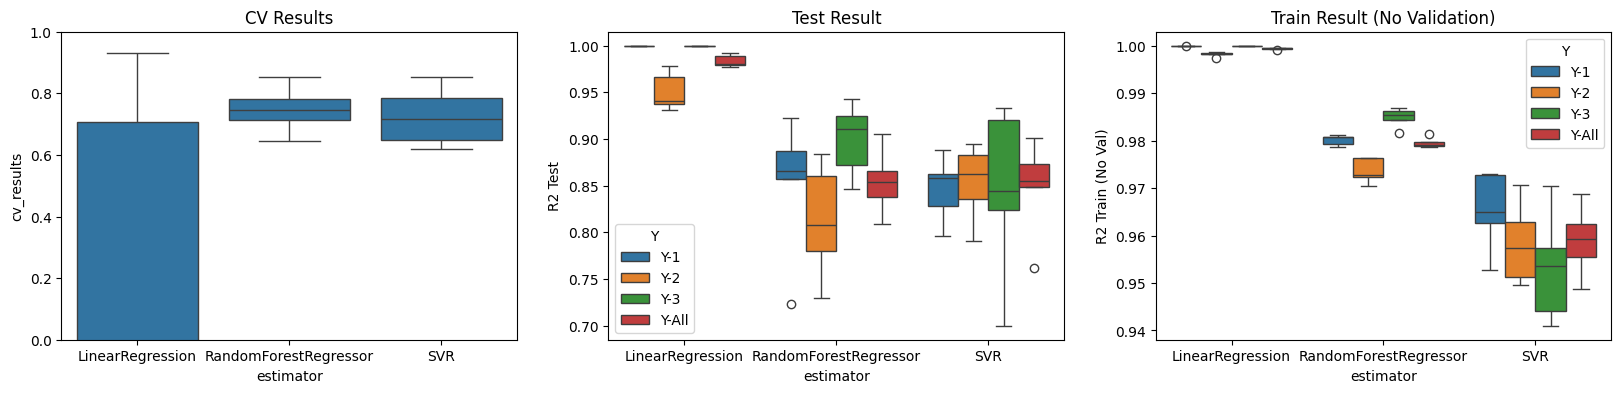

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(20, 4))

# Plot CV results
sns.boxplot(cv_data, x="estimator", y="cv_results", ax=axes[0])
axes[0].set_ylim([0, 1])
axes[0].set_title("CV Results")

# Plot test results
ax = sns.boxplot(data=df_eval, x="estimator", y="R2 Test", hue="Y", ax=axes[1])
axes[1].set_title("Test Result")

# Plot train (no cv) results
sns.boxplot(data=df_eval, x="estimator", y="R2 Train (No Val)", hue="Y", ax=axes[2])
axes[2].set_title("Train Result (No Validation)")

if SAVE_PLOT:
    filename = f"S05_eval_{dt}.png"
    fig.savefig(filename, dpi=300, bbox_inches="tight")

### Save data

In [ ]:
if SAVE_DATA:
    filename = f"S05_data_{dt}.pkl"

    data_save = {
        "desc": "This is the saved data",
        "filenameInput": filename,
        "df_eval": df_eval,
        "cv_data": cv_data,
    }

    # Save the model
    MyUtil.save_data(filename=filename, data=data_save)

### Test loading data


In [16]:
if SAVE_DATA:
    data_load = MyUtil.load_data(filename=filename)

    pp(list(data_load.keys()))

['desc', 'filenameInput', 'df_eval', 'cv_data']
